# IMBALANCED DATASET HANDLING

As will be shown later on, one major issue for fraud detection is the fact that the data is very imbalanced. Indeed, there is only a very few number of fraudulent transactions compared to the number of non-fraudulent ones.

Through this notebook we will analyze similar data and try to elaborate different methods that could allow us to improve the fraud classifier.

The data we will use are available on Kaggle and correspond to credit card transactions. <br>
>⇒ ‘creditcard.csv’ file was used (from Kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud)

Here is the description provided with the data:

><font size=5>**Content**</font> <br>
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Libraries to import

In [4]:
## IMPORTS
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import recall_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA


## DATA ANLYSIS

In [3]:
## FUNCTION TO PLOT A CONFUSION MATRIX
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

First, we load the data from the csv file into a pandas DataFrame. Then we seperate the label (the column 'Class') and do a plit for the training and the testing sets. We set a ratio of 0.1 for this split.

In [5]:
df = pd.read_csv('creditcard.csv')

X = df
Y = X['Class']
del X['Class']

#Xtraining, Xtest, Ytraining, Ytest = train_test_split(X, Y, test_size = 0.1, random_state = 42)
Xtraining = X.values
Ytraining = Y.values

sss = StratifiedShuffleSplit(test_size=0.3, random_state=42)
for train_index, test_index in sss.split(Xtraining, Ytraining):
    Xtrain, Xval = Xtraining[train_index], Xtraining[test_index]
    Ytrain, Yval = Ytraining[train_index], Ytraining[test_index]


Let us compare the number of frauds against the number of non frauds:

Number of frauds: 492
Number of non-frauds: 284315
Ratio frauds/non-frauds: 0.0017304750013189597


Text(0,0.5,'Number of transaction')

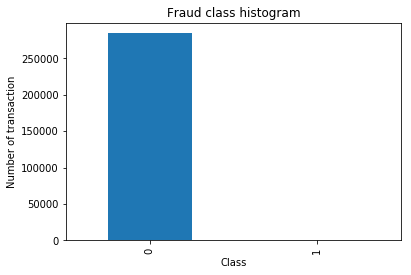

In [6]:
print('Number of frauds: {}'.format(len(Y[Y==1])))
print('Number of non-frauds: {}'.format(len(Y[Y==0])))
print('Ratio frauds/non-frauds: {}'.format(len(Y[Y==1])/len(Y[Y==0])))

count_classes = pd.value_counts(Y, sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Number of transaction")

Obviously, the data is totally imbalanced. Predicting all the data as non-frauds (prediction = 0) leads to an accuracy of 99.8%

There are two possibilities to handle this problem: under-sampling and over-sampling. Here we will test and evaluate the performances of over-sampling. We could decide to only replicate the fraudulent transactions we have in our data, but that would lead to overfitting on these data. We will instead use SMOTE (Synthetic Minority Over-sampling TEchnique).

Here is a quick explanation on the SMOTE algorithm: <br>
    - for each sample of the minority class, find the k Nearest Neighbor
    - select randomly some of these neighbors and create a sample between the latter and each of the chosen neighbor

### Performances without any oversampling

Let use for this case a Random Classifier with 25 estimators:

In [99]:
clf_rf_non_SMOTE = RandomForestClassifier(n_estimators=25, random_state=42)
#Xtrain, Xval, Ytrain, Yval = train_test_split(Xtraining, Ytraining, test_size = 0.3, random_state = 42)

In [100]:
clf_rf_non_SMOTE.fit(Xtrain, Ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [101]:
print('Score on the validation set:')
print(classification_report(Yval, clf_rf_non_SMOTE.predict(Xval)))
print('\nScore on the test set:')
print(classification_report(Ytest, clf_rf_non_SMOTE.predict(Xtest)))
print('\nScore on the training set:')
print(classification_report(Ytrain, clf_rf_non_SMOTE.predict(Xtrain)))

Score on the validation set:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85295
          1       0.91      0.78      0.84       148

avg / total       1.00      1.00      1.00     85443


Score on the test set:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85295
          1       0.91      0.78      0.84       148

avg / total       1.00      1.00      1.00     85443


Score on the training set:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    199020
          1       1.00      0.99      0.99       344

avg / total       1.00      1.00      1.00    199364



A good visual way to analyse the result and the performances measures is to compute the confusion matrix:

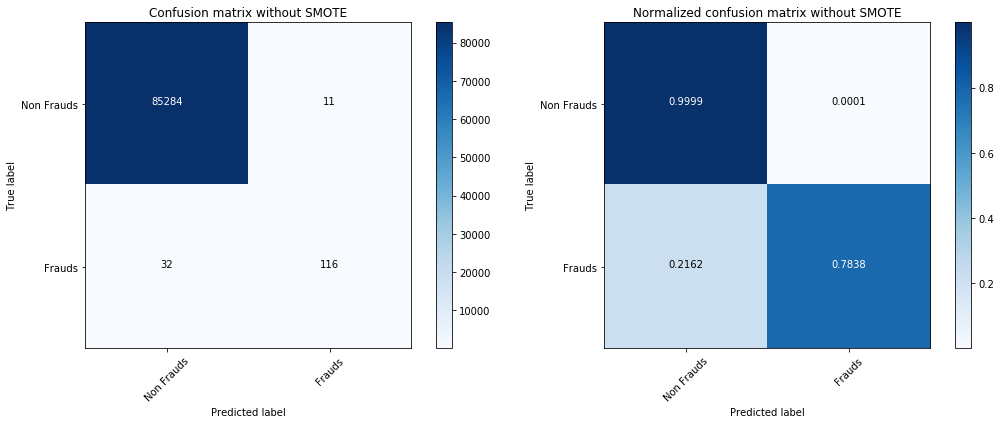

In [102]:
cm_nonSMOTE = confusion_matrix(y_true=Yval, y_pred=clf_rf_non_SMOTE.predict(Xval))
plt.figure(figsize=(15,6))
plt.subplot(121)
plot_confusion_matrix(cm_nonSMOTE, classes=['Non Frauds', 'Frauds'], normalize=False, title='Confusion matrix without SMOTE')

plt.subplot(122)
plot_confusion_matrix(cm_nonSMOTE, classes=['Non Frauds', 'Frauds'], normalize=True, title='Normalized confusion matrix without SMOTE')
plt.show()

When oversampling, we have to be very careful of when tp split the data and when to oversample. The right way to do it is to first seperate the data into a training set and a validation set, and then oversample the training set. Indeed, if the oversampling is done beforhand, we can lose information for the training because of the same information several times in the training. Indeed, even though the SMOTE algorithme does not simply replicate the samples, it uses k-NN and the information is too similar to perform on complex situations.

In [103]:
# Proper way to do oversampling
#Xtrain, Xval, Ytrain, Yval = train_test_split(Xtraining, Ytraining, test_size = 0.3, random_state = 42)
sm = SMOTE(random_state = 42)
Xtrain_sm, Ytrain_sm = sm.fit_sample(Xtrain, Ytrain)

Let us see now how the data has been upsampled:

Before SMOTE:
Number of frauds: 344
Number of non-frauds: 199020
Ratio frauds/non-frauds: 0.0017284695005527083

After SMOTE:
Number of frauds: 199020
Number of non-frauds: 199020
Ratio frauds/non-frauds: 1.0


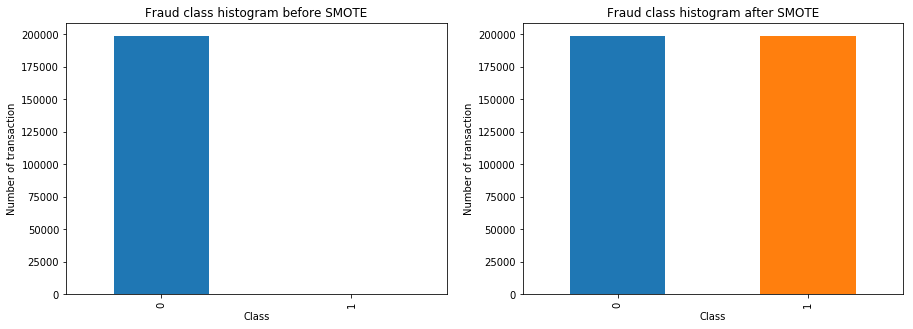

In [104]:
fig = plt.figure(figsize=(15,5))
plt.subplot(121)
count_classes_before_SMOTE = pd.value_counts(Ytrain, sort = True).sort_index()
count_classes_after_SMOTE = pd.value_counts(Ytrain_sm, sort = True).sort_index()
count_classes_before_SMOTE.plot(kind = 'bar')
plt.title("Fraud class histogram before SMOTE")
plt.xlabel("Class")
plt.ylabel("Number of transaction")
plt.subplot(122)
count_classes_after_SMOTE.plot(kind = 'bar')
plt.title("Fraud class histogram after SMOTE")
plt.xlabel("Class")
plt.ylabel("Number of transaction")

print('Before SMOTE:')
print('Number of frauds: {}'.format(len(Ytrain[Ytrain==1])))
print('Number of non-frauds: {}'.format(len(Ytrain[Ytrain==0])))
print('Ratio frauds/non-frauds: {}'.format(len(Ytrain[Ytrain==1])/len(Ytrain[Ytrain==0])))

print('\nAfter SMOTE:')
print('Number of frauds: {}'.format(len(Ytrain_sm[Ytrain_sm==1])))
print('Number of non-frauds: {}'.format(len(Ytrain_sm[Ytrain_sm==0])))
print('Ratio frauds/non-frauds: {}'.format(len(Ytrain_sm[Ytrain_sm==1])/len(Ytrain_sm[Ytrain_sm==0])))

As can be seen, thanks to the SMOTE algorithm we have now the same number of fraudulent and genuine transactions **for the training set**. <br>

We will now instantiate a PCA object with 3 components for visualisation purposes and observe the generated data.

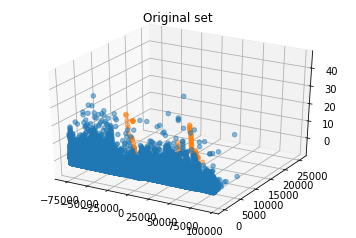

In [71]:
pca = PCA(n_components=3)
X_vis = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
c0 = ax.scatter(X_vis[Y == 0, 0], X_vis[Y == 0, 1], X_vis[Y == 0, 2], label="Non Frauds", alpha=0.5)
c1 = ax.scatter(X_vis[Y == 1, 0], X_vis[Y == 1, 1], X_vis[Y == 1, 2], label="Frauds", alpha=0.5)
ax.set_title('Original set')

In [105]:
clf_rf = RandomForestClassifier(n_estimators=25, random_state=42)

We will train this classifier on the training set which contains all these new samples created from the SMOTE algorithm.

In [106]:
clf_rf.fit(Xtrain_sm, Ytrain_sm)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [107]:
print('Score on the validation set:')
print(classification_report(Yval, clf_rf.predict(Xval)))
print('\nScore on the test set:')
print(classification_report(Ytest, clf_rf.predict(Xtest)))
print('\nScore on the training set with over-sampling:')
print(classification_report(Ytrain_sm, clf_rf.predict(Xtrain_sm)))
print('\nScore on the training set without over-sampling:')
print(classification_report(Ytrain, clf_rf.predict(Xtrain)))

Score on the validation set:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85295
          1       0.86      0.84      0.85       148

avg / total       1.00      1.00      1.00     85443


Score on the test set:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85295
          1       0.86      0.84      0.85       148

avg / total       1.00      1.00      1.00     85443


Score on the training set with over-sampling:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    199020
          1       1.00      1.00      1.00    199020

avg / total       1.00      1.00      1.00    398040


Score on the training set without over-sampling:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    199020
          1       0.99      1.00      1.00       344

avg / total       1.00      1.00      1.00  

There is clearly an improvement in the recall. Let us analyze the confusion matrix to compare the differences.


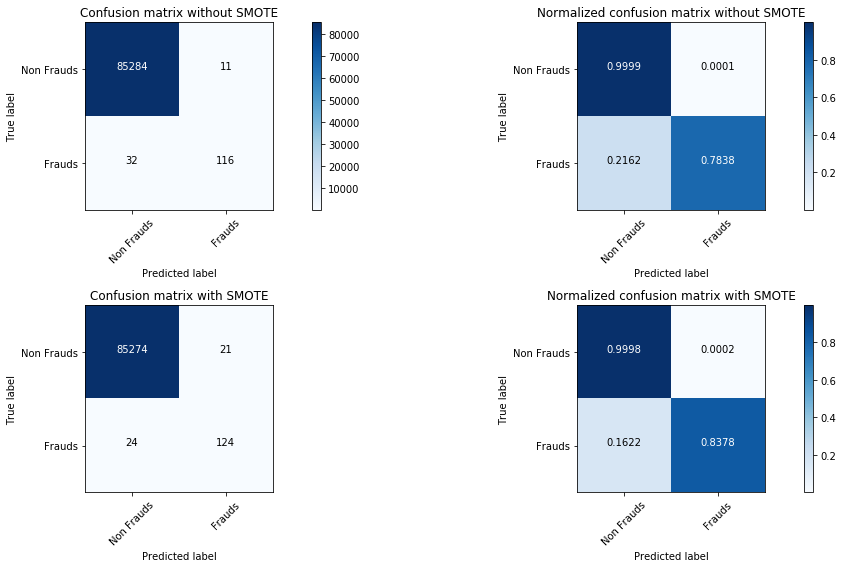

In [108]:
cm_SMOTE = confusion_matrix(y_true=Yval, y_pred=clf_rf.predict(Xval))
plt.figure(figsize=(18,8))
plt.subplot(221)
plot_confusion_matrix(cm_nonSMOTE, classes=['Non Frauds', 'Frauds'], normalize=False, title='Confusion matrix without SMOTE')

plt.subplot(222)
plot_confusion_matrix(cm_nonSMOTE, classes=['Non Frauds', 'Frauds'], normalize=True, title='Normalized confusion matrix without SMOTE')

cm_nonSMOTE = confusion_matrix(y_true=Yval, y_pred=clf_rf_non_SMOTE.predict(Xval))
plt.subplot(223)
plot_confusion_matrix(cm_SMOTE, classes=['Non Frauds', 'Frauds'], normalize=False, title='Confusion matrix with SMOTE')

plt.subplot(224)
plot_confusion_matrix(cm_SMOTE, classes=['Non Frauds', 'Frauds'], normalize=True, title='Normalized confusion matrix with SMOTE')
plt.show()

We can now see direcly that we have indeed more true positives and we managed to decrease the false negatives. However we have increased the false positives. Let us try with a weaker classifier to see if this behavior will remain.

In [109]:
clf_weak = RandomForestClassifier(n_estimators=5, random_state=42)
clf_weak_nonSMOTE = RandomForestClassifier(n_estimators=5, random_state=42)

In [110]:
clf_weak_nonSMOTE.fit(Xtrain, Ytrain)
clf_weak.fit(Xtrain_sm, Ytrain_sm)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [111]:
print('*** Without SMOTE: ***')
print('\nScore on the validation set:')
print(classification_report(Yval, clf_weak_nonSMOTE.predict(Xval)))
print('\nScore on the test set:')
print(classification_report(Ytest, clf_weak_nonSMOTE.predict(Xtest)))
print('\nScore on the training set with over-sampling:')
print(classification_report(Ytrain_sm, clf_weak_nonSMOTE.predict(Xtrain_sm)))
print('\nScore on the training set without over-sampling:')
print(classification_report(Ytrain, clf_weak_nonSMOTE.predict(Xtrain)))


print('\n\n*** With SMOTE: ***')
print('\nScore on the validation set:')
print(classification_report(Yval, clf_weak.predict(Xval)))
print('\nScore on the test set:')
print(classification_report(Ytest, clf_weak.predict(Xtest)))
print('\nScore on the training set with over-sampling:')
print(classification_report(Ytrain_sm, clf_weak.predict(Xtrain_sm)))
print('\nScore on the training set without over-sampling:')
print(classification_report(Ytrain, clf_weak.predict(Xtrain)))

*** Without SMOTE: ***

Score on the validation set:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85295
          1       0.90      0.75      0.82       148

avg / total       1.00      1.00      1.00     85443


Score on the test set:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85295
          1       0.90      0.75      0.82       148

avg / total       1.00      1.00      1.00     85443


Score on the training set with over-sampling:
             precision    recall  f1-score   support

          0       0.83      1.00      0.91    199020
          1       1.00      0.80      0.89    199020

avg / total       0.92      0.90      0.90    398040


Score on the training set without over-sampling:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    199020
          1       0.99      0.97      0.98       344

avg / total       1.

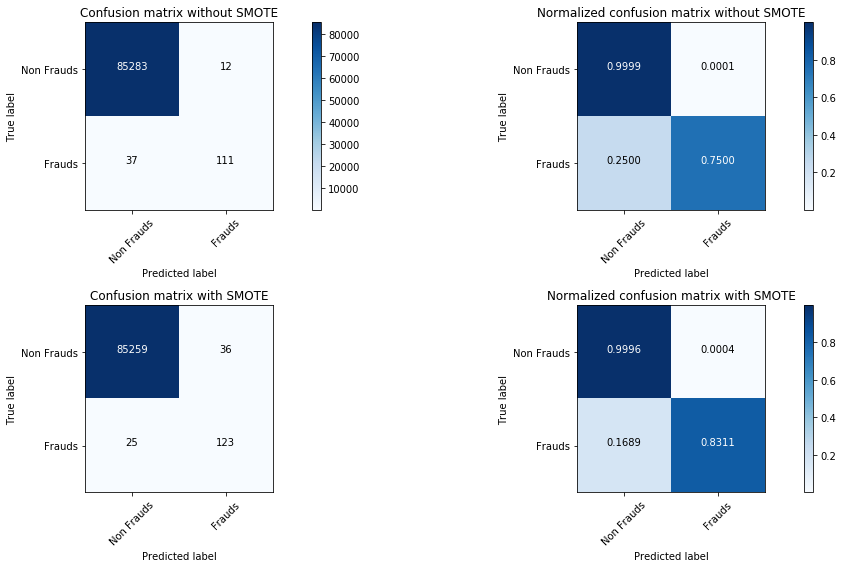

In [112]:
cm_weak_nonSMOTE = confusion_matrix(y_true=Yval, y_pred=clf_weak_nonSMOTE.predict(Xval))
cm_weak_SMOTE = confusion_matrix(y_true=Yval, y_pred=clf_weak.predict(Xval))

plt.figure(figsize=(18,8))
plt.subplot(221)
plot_confusion_matrix(cm_weak_nonSMOTE, classes=['Non Frauds', 'Frauds'], normalize=False, title='Confusion matrix without SMOTE')

plt.subplot(222)
plot_confusion_matrix(cm_weak_nonSMOTE, classes=['Non Frauds', 'Frauds'], normalize=True, title='Normalized confusion matrix without SMOTE')

plt.subplot(223)
plot_confusion_matrix(cm_weak_SMOTE, classes=['Non Frauds', 'Frauds'], normalize=False, title='Confusion matrix with SMOTE')

plt.subplot(224)
plot_confusion_matrix(cm_weak_SMOTE, classes=['Non Frauds', 'Frauds'], normalize=True, title='Normalized confusion matrix with SMOTE')

plt.show()

Here again for a weaker classfier we have the same results in the change of the performances measures when we use SMOTE for oversampling.

Some papers claim that some data cleaning method prior to the resampling can lead to better results. One particular method used quite often is the Tomek Link Removal (called also T-link removal). The goal of this method is to remove the noise and borderline samples.
![sphx_glr_plot_illustration_tomek_links_001.png](attachment:sphx_glr_plot_illustration_tomek_links_001.png)
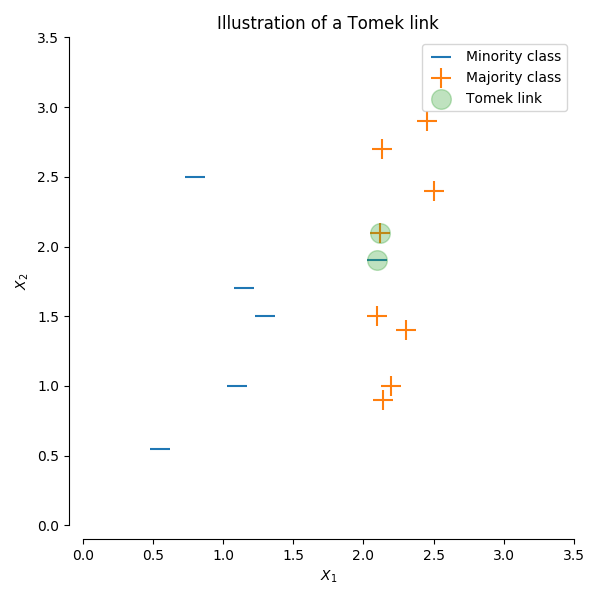

T-links removal is an under-sampling technique which is available in the imblearn library. Moreover, we will directly focus on the combination of SMOTE with T-links removal, which is available with the SMOTETomek class from imblearn.combine.

In [113]:
smtl = SMOTETomek(random_state=42)
smeen = SMOTEENN(random_state=42)
Xtrain_smtl, Ytrain_smtl = smtl.fit_sample(Xtrain, Ytrain)
Xtrain_smeen, Ytrain_smeen = smeen.fit_sample(Xtrain, Ytrain)

clf_rf_smtl = RandomForestClassifier(n_estimators=25, random_state=42)
clf_rf_smtl.fit(Xtrain_smtl, Ytrain_smtl)

clf_rf_smeen = RandomForestClassifier(n_estimators=25, random_state=42)
clf_rf_smeen.fit(Xtrain_smeen, Ytrain_smeen)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

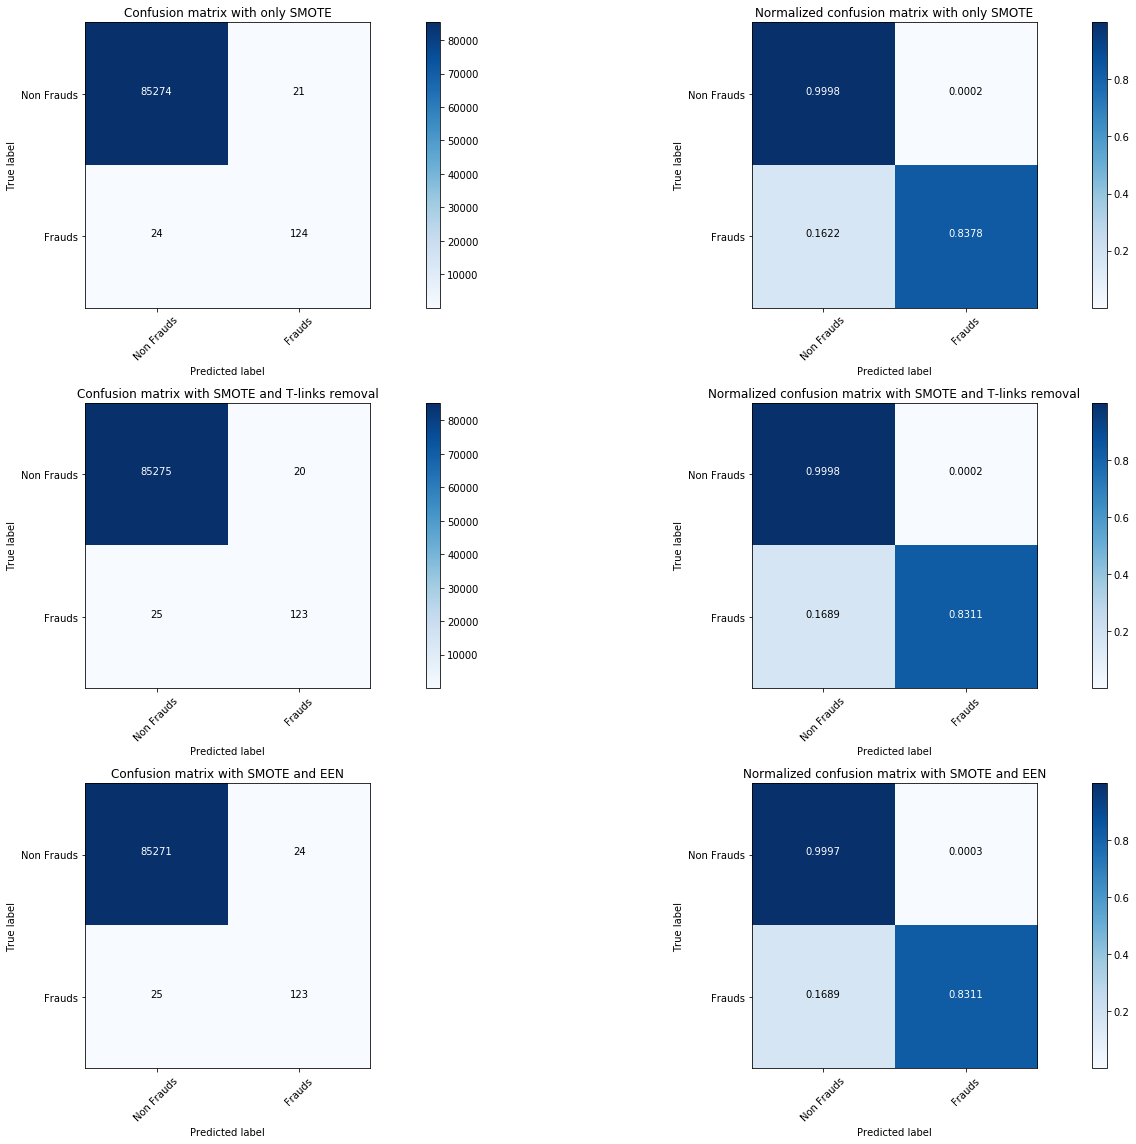

In [114]:
cm_smtl = confusion_matrix(y_true=Yval, y_pred=clf_rf_smtl.predict(Xval))
cm_smeen = confusion_matrix(y_true=Yval, y_pred=clf_rf_smeen.predict(Xval))
plt.figure(figsize=(25,16))
plt.subplot(321)
plot_confusion_matrix(cm_SMOTE, classes=['Non Frauds', 'Frauds'], normalize=False, title='Confusion matrix with only SMOTE')

plt.subplot(322)
plot_confusion_matrix(cm_SMOTE, classes=['Non Frauds', 'Frauds'], normalize=True, title='Normalized confusion matrix with only SMOTE')

plt.subplot(323)
plot_confusion_matrix(cm_smtl, classes=['Non Frauds', 'Frauds'], normalize=False, title='Confusion matrix with SMOTE and T-links removal')

plt.subplot(324)
plot_confusion_matrix(cm_smtl, classes=['Non Frauds', 'Frauds'], normalize=True, title='Normalized confusion matrix with SMOTE and T-links removal')

plt.subplot(325)
plot_confusion_matrix(cm_smeen, classes=['Non Frauds', 'Frauds'], normalize=False, title='Confusion matrix with SMOTE and EEN')

plt.subplot(326)
plot_confusion_matrix(cm_smeen, classes=['Non Frauds', 'Frauds'], normalize=True, title='Normalized confusion matrix with SMOTE and EEN')
plt.show()

In [115]:
tl = TomekLinks(random_state=42)
Xtrain_tl, Ytrain_tl = tl.fit_sample(Xtrain, Ytrain)

Xtrain_sm_cleaned, Ytrain_sm_cleaned = sm.fit_sample(Xtrain_tl, Ytrain_tl)

In [118]:
clf_rf_sm_cleaned = RandomForestClassifier(n_estimators=500, random_state=42)
clf_rf_sm_cleaned.fit(Xtrain_sm_cleaned, Ytrain_sm_cleaned)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

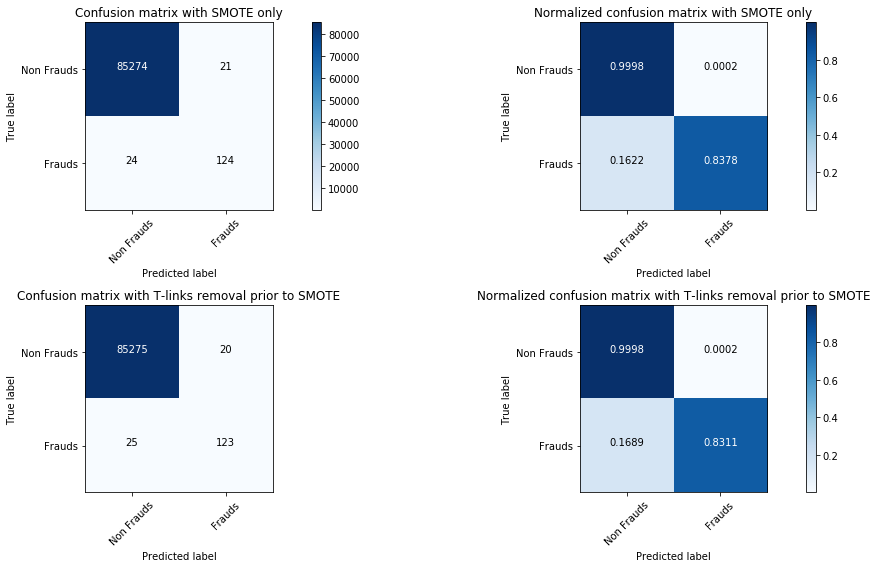

In [119]:
cm_sm_cleaned = confusion_matrix(y_true=Yval, y_pred=clf_rf_sm_cleaned.predict(Xval))

plt.figure(figsize=(18,8))
plt.subplot(221)
plot_confusion_matrix(cm_SMOTE, classes=['Non Frauds', 'Frauds'], normalize=False, title='Confusion matrix with SMOTE only')

plt.subplot(222)
plot_confusion_matrix(cm_SMOTE, classes=['Non Frauds', 'Frauds'], normalize=True, title='Normalized confusion matrix with SMOTE only')

plt.subplot(223)
plot_confusion_matrix(cm_sm_cleaned, classes=['Non Frauds', 'Frauds'], normalize=False, title='Confusion matrix with T-links removal prior to SMOTE')

plt.subplot(224)
plot_confusion_matrix(cm_sm_cleaned, classes=['Non Frauds', 'Frauds'], normalize=True, title='Normalized confusion matrix with T-links removal prior to SMOTE')

plt.show()

### Incremental training on Gradient Boosting Classifier

In [29]:
Xtraining = X.values
Ytraining = Y.values

tr_te_split = StratifiedShuffleSplit(test_size=0.2, random_state=42)
for train_index, test_index in tr_te_split.split(Xtraining, Ytraining):
    Xtrain, Xtest = Xtraining[train_index], Xtraining[test_index]
    Ytrain, Ytest = Ytraining[train_index], Ytraining[test_index]
    
incr_part_split = StratifiedShuffleSplit(test_size=0.4, random_state=42)
for train_index, test_index in incr_part_split.split(Xtrain, Ytrain):
    Xincr, Xremain = Xtrain[train_index], Xtrain[test_index]
    Yincr, Yremain = Ytrain[train_index], Ytrain[test_index]

In [36]:
gbt = GradientBoostingClassifier(
        learning_rate = 0.1,
        n_estimators = 100,
        subsample = 1.0,
        max_depth = 3)
 
df = BaggingClassifier(
        base_estimator = gbt,
        n_estimators = 10,
        max_samples = 0.8,
        n_jobs = 1,
        max_features = 0.8)

model_incremental = df.fit(Xincr, Yincr)

In [37]:
gbt = GradientBoostingClassifier(
        learning_rate = 0.1,
        n_estimators = 100,
        subsample = 1.0,
        max_depth = 3)
 
df = BaggingClassifier(
        base_estimator = gbt,
        n_estimators = 10,
        max_samples = 0.8,
        n_jobs = 1,
        max_features = 0.8)

model_full = df.fit(Xtrain, Ytrain)

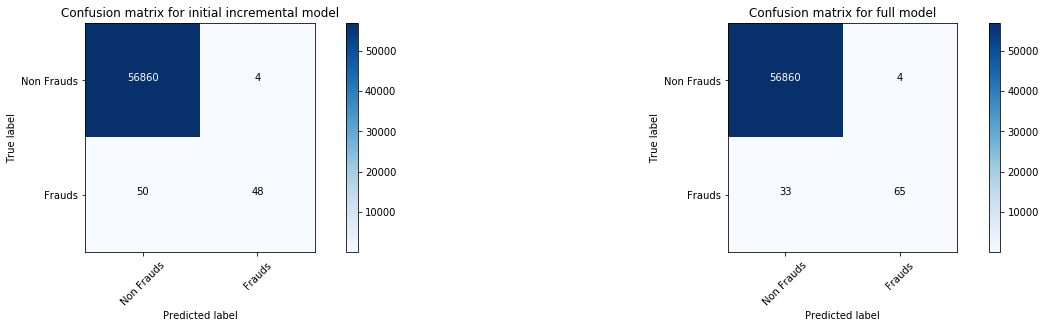

In [90]:
cm_incr_init = confusion_matrix(y_true=Ytest, y_pred=model_incremental.predict(Xtest))
cm_full = confusion_matrix(y_true=Ytest, y_pred=model_full.predict(Xtest))

plt.figure(figsize=(18,8))
plt.subplot(221)
plot_confusion_matrix(cm_incr_init, classes=['Non Frauds', 'Frauds'], normalize=False, title='Confusion matrix for initial incremental model')
plt.subplot(222)
plot_confusion_matrix(cm_full, classes=['Non Frauds', 'Frauds'], normalize=False, title='Confusion matrix for full model')

In [91]:
numberRemainingData = Xremain.shape[0]
model_incremental.warm_start = True

#for i in range(numberRemainingData):
#    print(i)
#    model_incremental.fit(Xremain[i].reshape(1,-1), Yremain[i])
model_incremental.fit(Xremain, Yremain)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:348: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


BaggingClassifier(base_estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=0.8,
         max_samples=0.8, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=True)

(30,)

## References: <br>
https://openreview.net/pdf?id=S1Auv-WRZ <br>
https://www.kaggle.com/joparga3/in-depth-skewed-data-classif-93-recall-acc-now <br>
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3648438/ (interesting results for SMOTE in conclusion) <br>
http://rikunert.com/SMOTE_explained (detailed explanations on SMOTE) <br>
https://www.youtube.com/watch?v=X9MZtvvQDR4 (Machine learning with imbalanced data sets) <br>
https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation (under-sampling, over-sampling and cross validation) <br>
http://datamining.imedpub.com/classification-of-imbalance-data-using-tomek-linktlink-combined-with-random-undersampling-rus-as-a-data-reduction-method.pdf (tomek link removal) <br>
http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/under-sampling/plot_illustration_tomek_links.html (illustration of Tomek Links) <br>